In [1]:
import numpy as np
import pandas as pd
from astropy.units import Quantity
from copy import copy, deepcopy
import matplotlib.pyplot as plt

from ctapipe.utils import get_dataset_path
from ctapipe.io import event_source
from ctapipe.visualization import CameraDisplay
from ctapipe.calib import CameraCalibrator 
from ctapipe.image import tailcuts_clean
from ctapipe.image import hillas_parameters_1, hillas_parameters_2, hillas_parameters_3, hillas_parameters_4, hillas_parameters_5 
from ctapipe.io.containers import HillasParametersContainer

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
infile = get_dataset_path('gamma_test_large.simtel.gz')
source = event_source(infile)

channel = 0
cal = CameraCalibrator(r1_product="HESSIOR1Calibrator", extractor_product="NeighbourPeakIntegrator")

In [4]:
# setup pandas DataFrames to store Hillas parameters

columns = HillasParametersContainer().keys()

hillas_functions = {}
hillas_dataframes = {}

for i, h in enumerate([hillas_parameters_1, hillas_parameters_2, hillas_parameters_3, hillas_parameters_4, hillas_parameters_5]):
    hillas_functions[i+1] = h
    hillas_dataframes[i+1] = pd.DataFrame(columns=columns)

In [5]:
for event in source:
    cal.calibrate(event)
    
    for tel_id in event.r0.tels_with_data:
        geom = event.inst.subarray.tel[tel_id].camera

        image = event.dl1.tel[tel_id].image[channel]
        event.dl1.tel[tel_id].cleaned = deepcopy(event.dl1.tel[tel_id].image)
        cleaned = event.dl1.tel[tel_id].cleaned[channel]
        
        signal_pixels = tailcuts_clean(geom, image,
                                       picture_thresh=6, 
                                       boundary_thresh=3,
                                       min_number_picture_neighbors=1,
                                      )
        
        cleaned[~signal_pixels] = 0 
        if not cleaned.sum() > 0:
            break
        
        for i, hillas_parameters in hillas_functions.items():
            hillas = hillas_parameters(geom, cleaned)
        
            data = pd.DataFrame([[Quantity(hillas[k]).value for k in columns],], columns=columns)
            hillas_dataframes[i] = pd.concat([hillas_dataframes[i], data])
        

In [6]:
hillas_dataframes[1].head()

,intensity,kurtosis,skewness,r,y,width,psi,length,x,phi
0,770.685680,1.732654,0.586551,0.436918,-0.356204,0.422859,1.067285,0.765995,-0.253015,-2.188407
0,502.159935,2.814573,0.918392,0.399612,-0.132020,0.440535,0.739477,0.536319,-0.377174,-2.804897
0,136.885686,1.631982,0.744693,0.079299,-0.068948,0.056506,0.265611,0.122538,-0.039173,-2.087471
0,525.580903,3.818257,1.403482,0.630480,-0.232651,0.337678,0.693165,0.537864,-0.585985,-2.763654
0,212.748101,2.014987,-0.478538,0.022572,0.000397,0.050641,1.320426,0.086725,-0.022569,3.124005


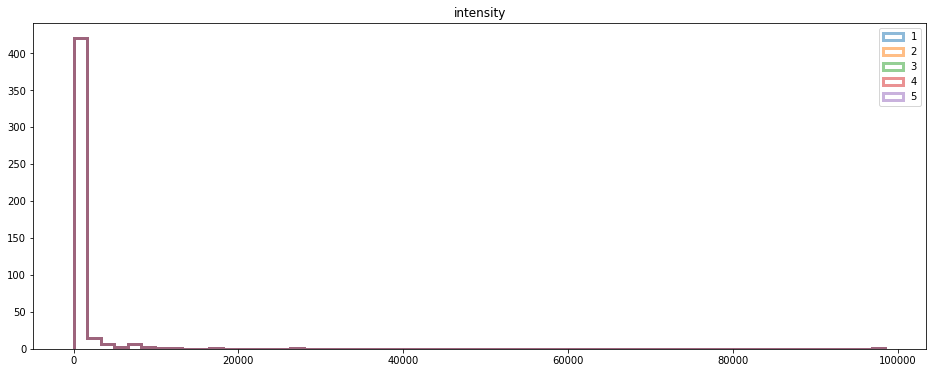

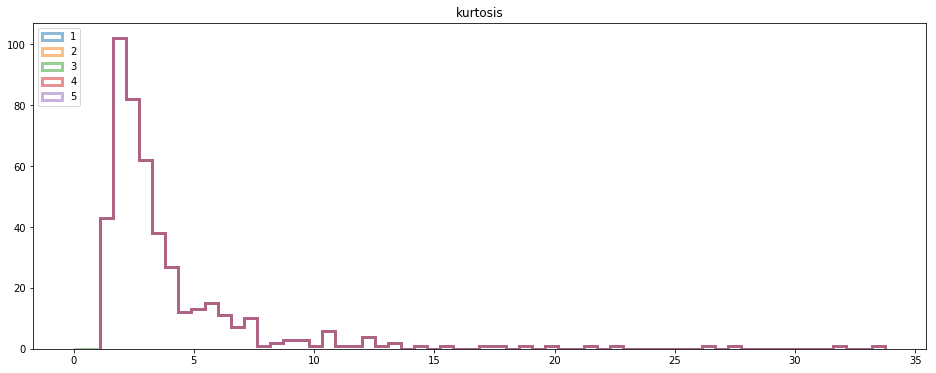

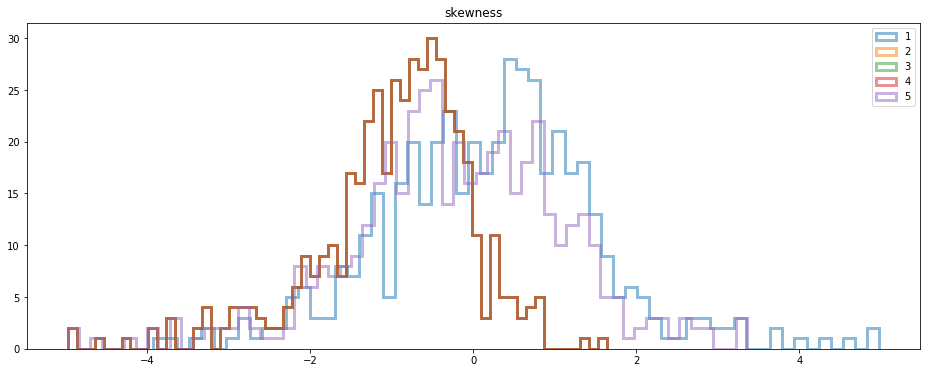

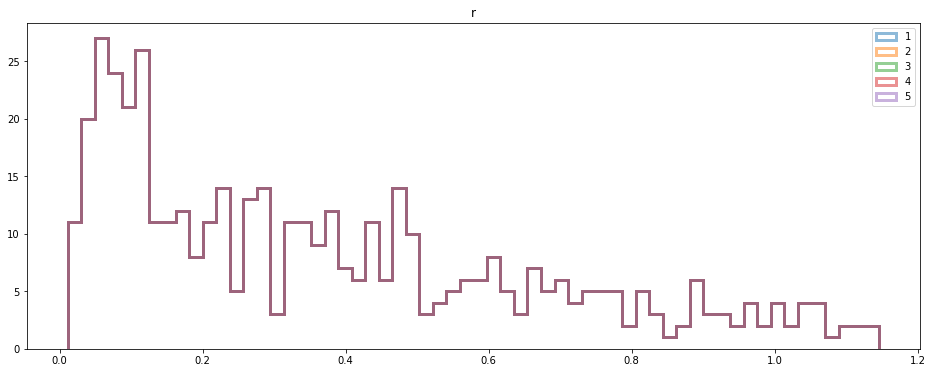

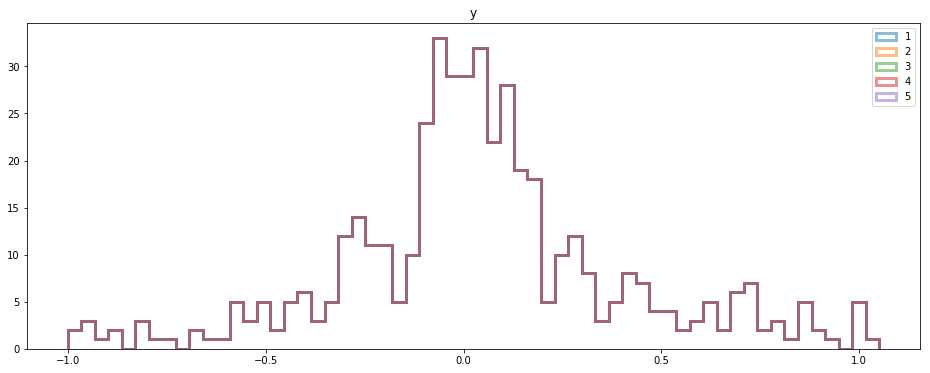

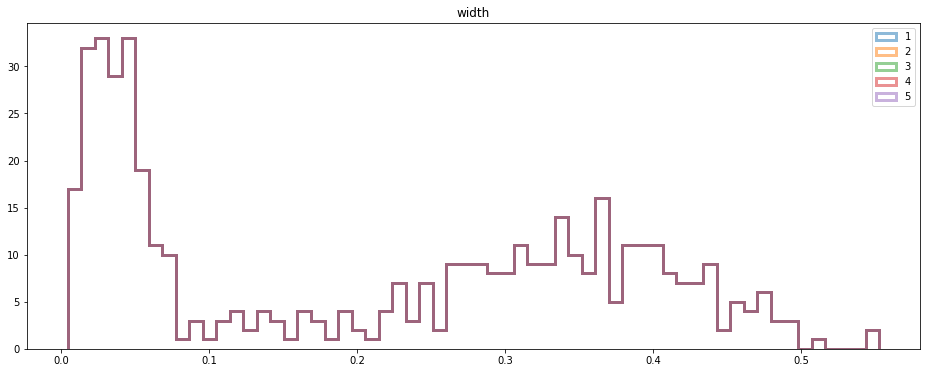

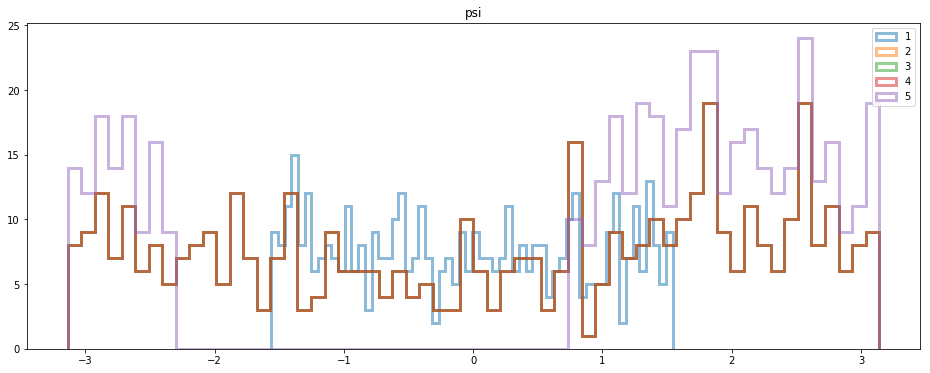

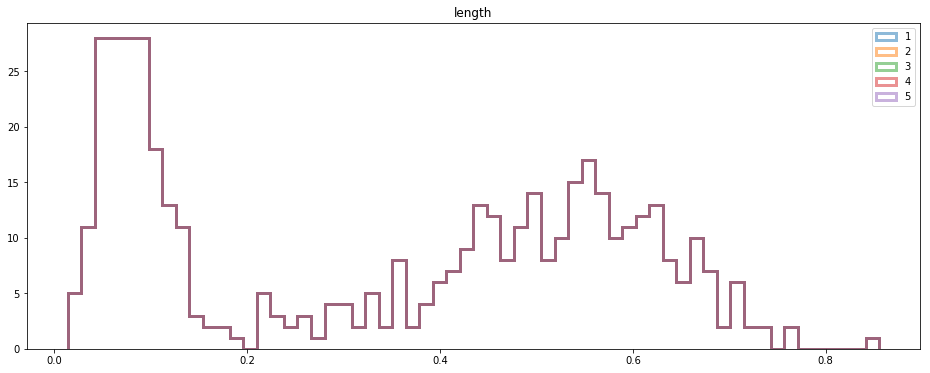

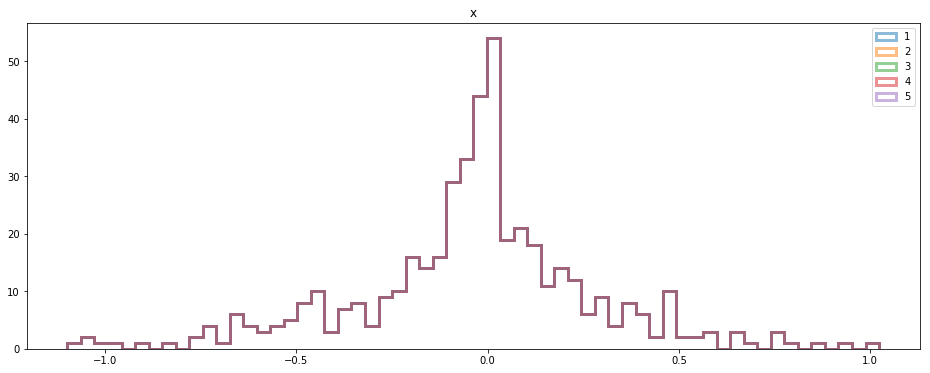

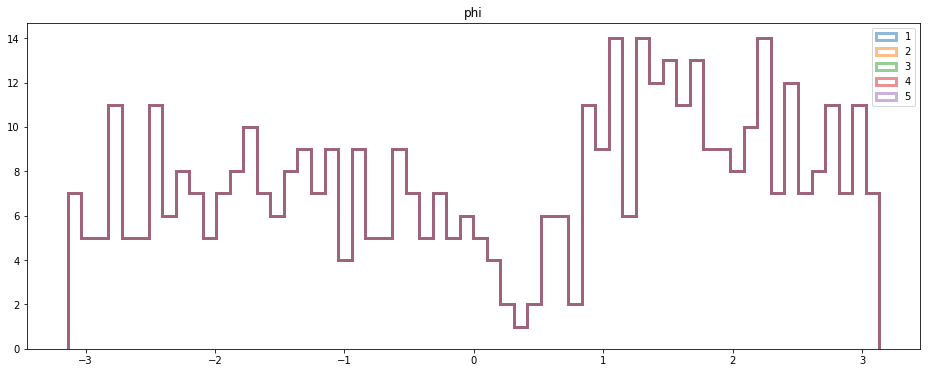

In [7]:
for k in columns:
    fig = plt.figure(figsize=(16,6))
    for i, hillas_df in hillas_dataframes.items():
        plt.hist(hillas_df[k].dropna(), bins=60, alpha=0.5, label=str(i), histtype='step', linewidth=3)
    plt.title(k)
    plt.legend()
    plt.show()

## Compared to the default ctapipe hillas: hillas_parameters_4

In [8]:
for i, hillas_df in hillas_dataframes.items():
    for k in columns:
        if not np.isclose(hillas_df[k], hillas_dataframes[4][k], rtol=1e-5).all():
            print("Parameter {} shows differences for hillas_parameters_{}".format(k, i))

Parameter skewness shows differences for hillas_parameters_1
Parameter psi shows differences for hillas_parameters_1
Parameter kurtosis shows differences for hillas_parameters_3
Parameter skewness shows differences for hillas_parameters_5
Parameter psi shows differences for hillas_parameters_5


Only three parameters give different results: psi, skewness, kurtosis

## Correlation matrix

In [9]:
mat = np.ones((6,6))
for i in hillas_dataframes:
    for j in hillas_dataframes:
        for k in columns:
            if not np.isclose(hillas_dataframes[i][k], hillas_dataframes[j][k], rtol=1e-5).all():
                mat[i,j] = 0
mat[:,0] = -1
mat[0,:] = -1

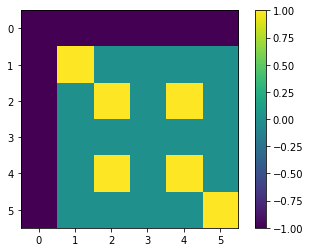

In [10]:
plt.imshow(mat)
plt.colorbar()

The matrix shows that only `hillas_parameters_2` and `hillas_parameters_4` gives the exact same results

Also, `hillas_parameters_3` always return `NaN` for the Kurtosis parameter:

In [11]:
hillas_dataframes[3]['kurtosis']

0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
     ..
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
Name: kurtosis, Length: 459, dtype: float64

---
# Computing performances

In [12]:
hillas_times = {}
for i, hillas_parameters in hillas_functions.items():
    print("hillas_parameters_{}".format(i))
    t = %timeit -o hillas_parameters(geom, cleaned)
    hillas_times[i] = t.average

hillas_parameters_1
2.4 ms ± 827 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
hillas_parameters_2
554 µs ± 145 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
hillas_parameters_3
1.67 ms ± 189 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
hillas_parameters_4
644 µs ± 56.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
hillas_parameters_5
863 µs ± 97.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


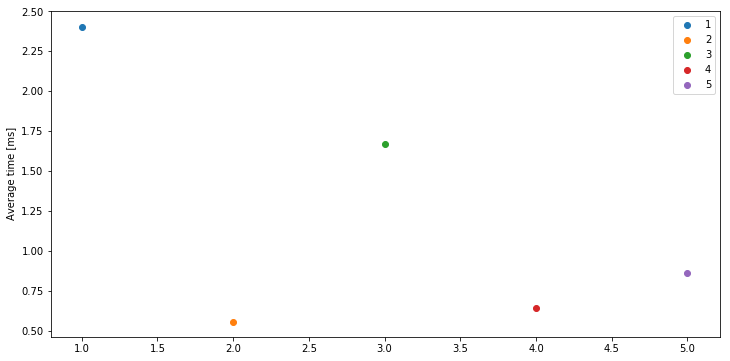

In [13]:
fig = plt.figure(figsize=(12,6))
for i in hillas_times:
    plt.scatter(i,hillas_times[i]*1e3, label=str(i))
plt.legend()
plt.ylabel("Average time [ms]");